# Data prep
Airbnb Seattle data **listings.csv** contains all the properties listed on 4th Jan 2016 including full descriptions, prices and average review scores.

This code cleans the data for use in Q2 and Q3. For a summary of the variables dropped/changed scroll to the very bottom.

Future work:
* Text columns
* URL scraping
* Create additional features from host_neighbourhood and host_location (too many categories) and amenities, host_verifications (entered as lists)
* Remove/investigate outliers
* Create binary fields 0 or >0 for many fields

## Set-up and read in data

In [4]:
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# print versions
print("Current version of Python is ", sys.version)
print("Current version of numpy is ",np.__version__)
print("Current version of Pandas is ",pd.__version__)
print("Current version of matplotlib is ",matplotlib.__version__)
print("Current version of seaborn is ",sns.__version__)

Current version of Python is  3.6.13 | packaged by conda-forge | (default, Feb 19 2021, 05:36:01) 
[GCC 9.3.0]
Current version of numpy is  1.19.5
Current version of Pandas is  1.1.5
Current version of matplotlib is  3.3.4
Current version of seaborn is  0.11.1


In [5]:
# read in data
df_listing = pd.read_csv('./listings.csv')

## Define user functions

In [6]:
#none

## Look at the data

The cells below tell us that:
* df_listing
    * 3,818  x 92
    * Date (last_scraped) is 2016-01-04
    * Dates should be datetime and price should be float.

In [7]:
# Look at first 5 rows and info and some value counts.

# df_listing.head() 
# df_listing.info()
df_listing["last_scraped"].value_counts()

2016-01-04    3818
Name: last_scraped, dtype: int64

## Drop variables


Drop the following:
* Columns with large number of Missing values
* IDs and URLs - the URLs themselves don't add value although you could scrape the info from website. Beyond my current skillset.
* Columns with a Single value
* Text columns - should be considered in future.Missing/non-missing, count of number of words, common words would be easy features to create. I assume there is a fancy python library that will do this but leaving out in the interest of time.

### Missing values


In [8]:
# Set-up dictionary so that I remember why I have dropped variables

# large no. of missings - license, square_feet.
drop_vars_dict = {'license': 'missing values', 'square_feet': 'missing values' }

### Ids and URLs



In [9]:
# Drop columns with 'url' and 'id' in the column name
column_list = df_listing.columns.values.tolist()

for i in column_list:
    if "url" in i or "id" in i : 
        if i != 'host_identity_verified':
            reason = 'id or url in name'
#             print(i)
            drop_vars_dict.update({i: reason})
            
# re-run but keep host_identity_verified
# Considered keeping host_id but can see there is a field for number of properties

### Text



In [10]:
# Extract text columns - look at no. of words
str_cols = list(df_listing.select_dtypes(include=['object']).columns)
l_text_cols= []
for c in str_cols:
    test = df_listing[c].str.count(' ').mean()
    if test > 0:
#         print(c+'               '+ str(test))
        l_text_cols.append(c)
#  have a look at transit, host_location

df_text_cols = df_listing[l_text_cols]
# df_text_cols.head()

In [11]:
# After looking at the top 5 rows of this df then decided to keep some fields that may be easy to encode 
# Will come back to these when I look at no. of categories.
# This might be useful but it is free text so drop for now - calendar_updated

keep = ['host_location' , 'host_neighbourhood', 'host_verifications', 'neighbourhood_group_cleansed', 'property_type', 'room_type', 'bed_type', 'amenities']
df_text_cols = [i for i in df_text_cols if i not in keep]

# Update my drop dictionary
for i in df_text_cols:
    reason = 'Text'
#     print(i)
    drop_vars_dict.update({i: reason})

### Single values



In [12]:
# Drop columns with single values 
counts= df_listing.nunique(dropna=False)
counts.sort_values(ascending=True)

single_val_col = counts[counts == 1]
l_single_val_col = list(single_val_col.index.values)

for i in l_single_val_col:
    if i != 'last_scraped':
        reason = 'single value'
        print(i)
        drop_vars_dict.update({i: reason})
    
# Also add in city
# I thought City would be all 1 - there a few random values in there but most are Seattle so dropping
drop_vars_dict.update({'city': 'single value'})
# drop_vars_dict

scrape_id
experiences_offered
market
country_code
country
has_availability
calendar_last_scraped
requires_license
license
jurisdiction_names


In [13]:
# Had a look to see what are in the columns with a single value. 
# for i in l_single_val_col:
#     print(df_listing[i].value_counts())
# Date is 2016-01-04

In [14]:
# Apply the drop 

drop_vars = [*drop_vars_dict.keys()]
df_listing_drop = df_listing.drop(drop_vars, axis = 1)
df_listing_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 55 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   last_scraped                      3818 non-null   object 
 1   host_since                        3816 non-null   object 
 2   host_location                     3810 non-null   object 
 3   host_response_rate                3295 non-null   object 
 4   host_acceptance_rate              3045 non-null   object 
 5   host_is_superhost                 3816 non-null   object 
 6   host_neighbourhood                3518 non-null   object 
 7   host_listings_count               3816 non-null   float64
 8   host_total_listings_count         3816 non-null   float64
 9   host_verifications                3818 non-null   object 
 10  host_has_profile_pic              3816 non-null   object 
 11  host_identity_verified            3816 non-null   object 
 12  neighb

## Categorical fields

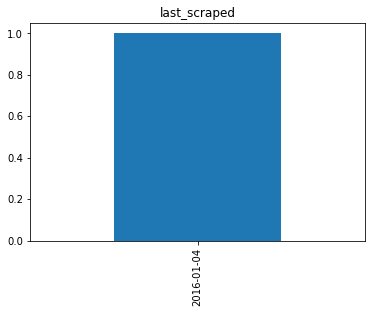

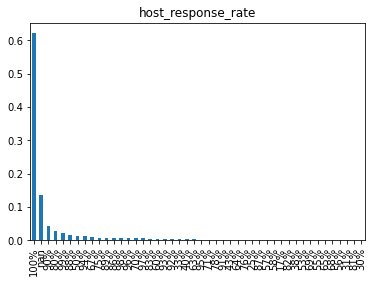

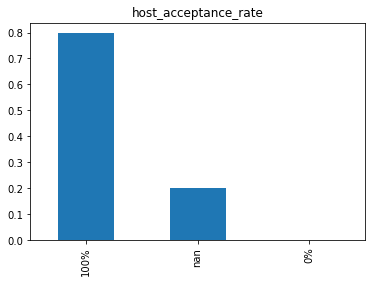

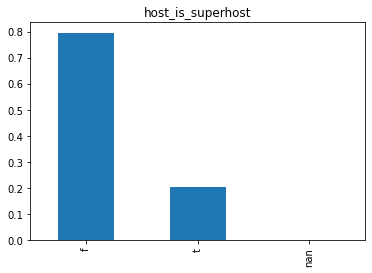

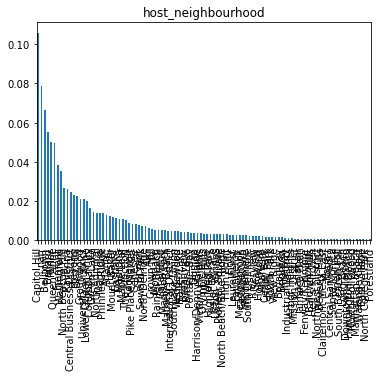

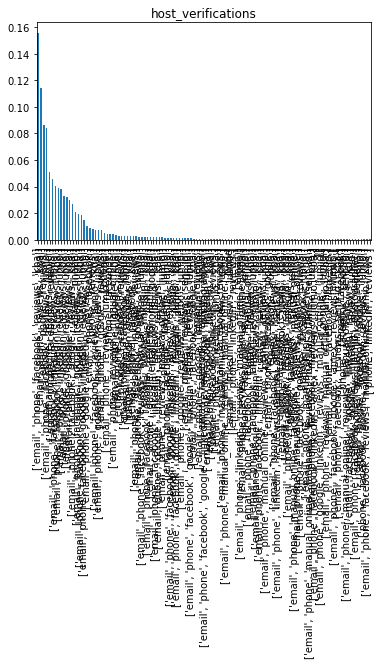

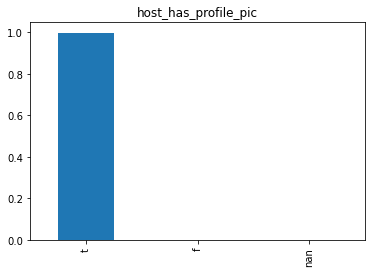

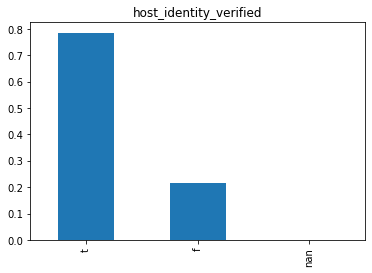

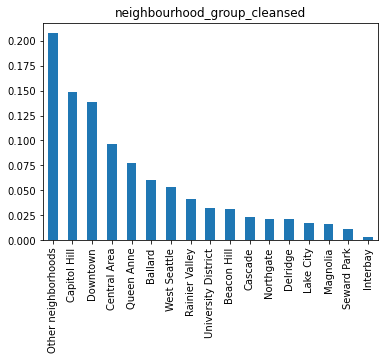

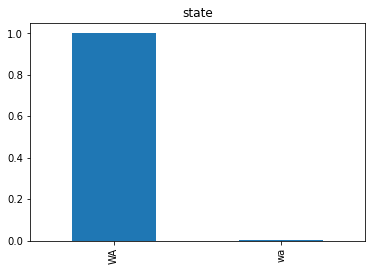

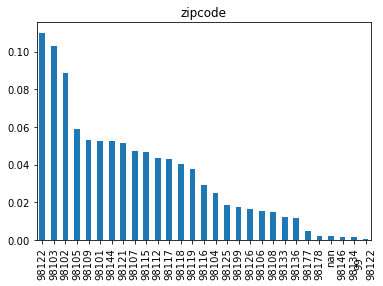

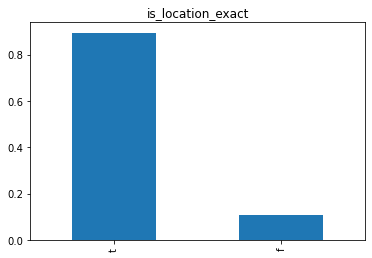

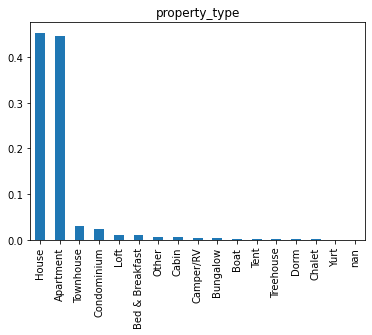

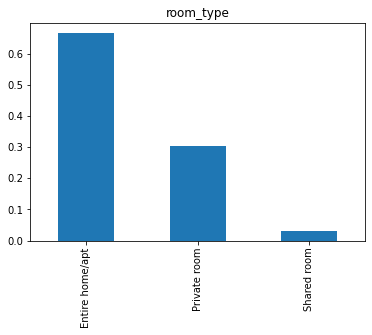

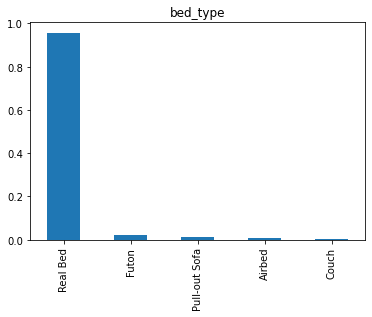

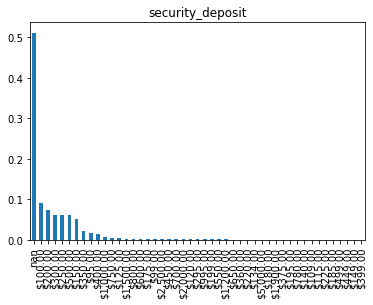

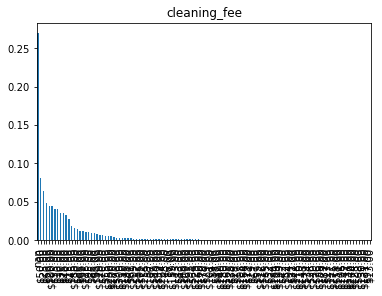

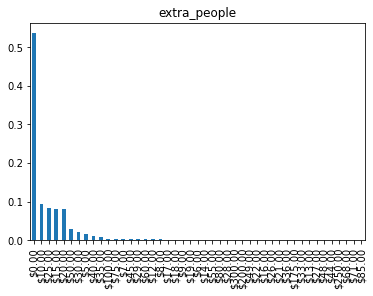

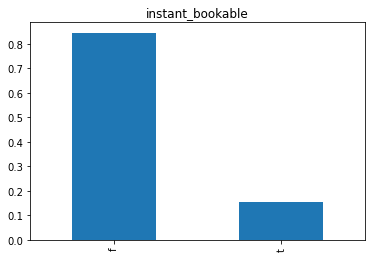

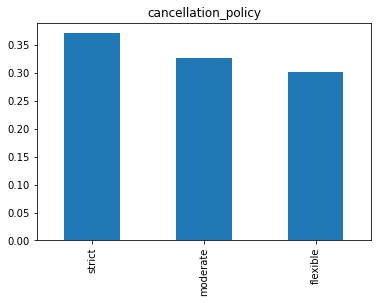

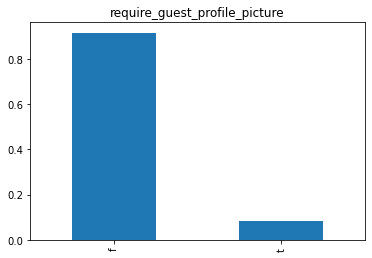

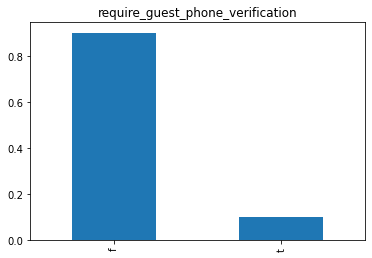

In [15]:
# Print some charts with variables with less than 120 categories

# List of columns with less than 120 categories
counts2= df_listing_drop.nunique(dropna=False)
counts2.sort_values(ascending=True)
val_col = counts2[counts2 < 120]
l_low_val_col = list(val_col.index.values)
# Only keep elements in this list that are type object i.e. in str_cols_all
str_cols_all = list(df_listing_drop.select_dtypes(include=['object']).columns)
look_cat_cols = [i for i in l_low_val_col if i in str_cols_all]

# Graphs
for col in look_cat_cols:
    vals = df_listing[col].value_counts(dropna=False)
    (vals/df_listing.shape[0]).plot(kind="bar")
    plt.title(col)
    plt.show()

In [16]:
# look at top 5 rows of the categorical variables with lots of levels
val_colgt = counts2[counts2 > 120]
l_low_val_colgt = list(val_colgt.index.values)
look_cat_colsgt = [i for i in l_low_val_colgt if i in str_cols_all]
df_listing_drop[look_cat_colsgt].head()

,host_since,host_location,amenities,price,weekly_price,monthly_price,first_review,last_review
0,2011-08-11,"Seattle, Washington, United States","{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",$85.00,NaN,NaN,2011-11-01,2016-01-02
1,2013-02-21,"Seattle, Washington, United States","{TV,Internet,""Wireless Internet"",Kitchen,""Free...",$150.00,"$1,000.00","$3,000.00",2013-08-19,2015-12-29
2,2014-06-12,"Seattle, Washington, United States","{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",$975.00,NaN,NaN,2014-07-30,2015-09-03
3,2013-11-06,"Seattle, Washington, United States","{Internet,""Wireless Internet"",Kitchen,""Indoor ...",$100.00,$650.00,"$2,300.00",NaN,NaN
4,2011-11-29,"Seattle, Washington, United States","{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",$450.00,NaN,NaN,2012-07-10,2015-10-24


## Continuous fields

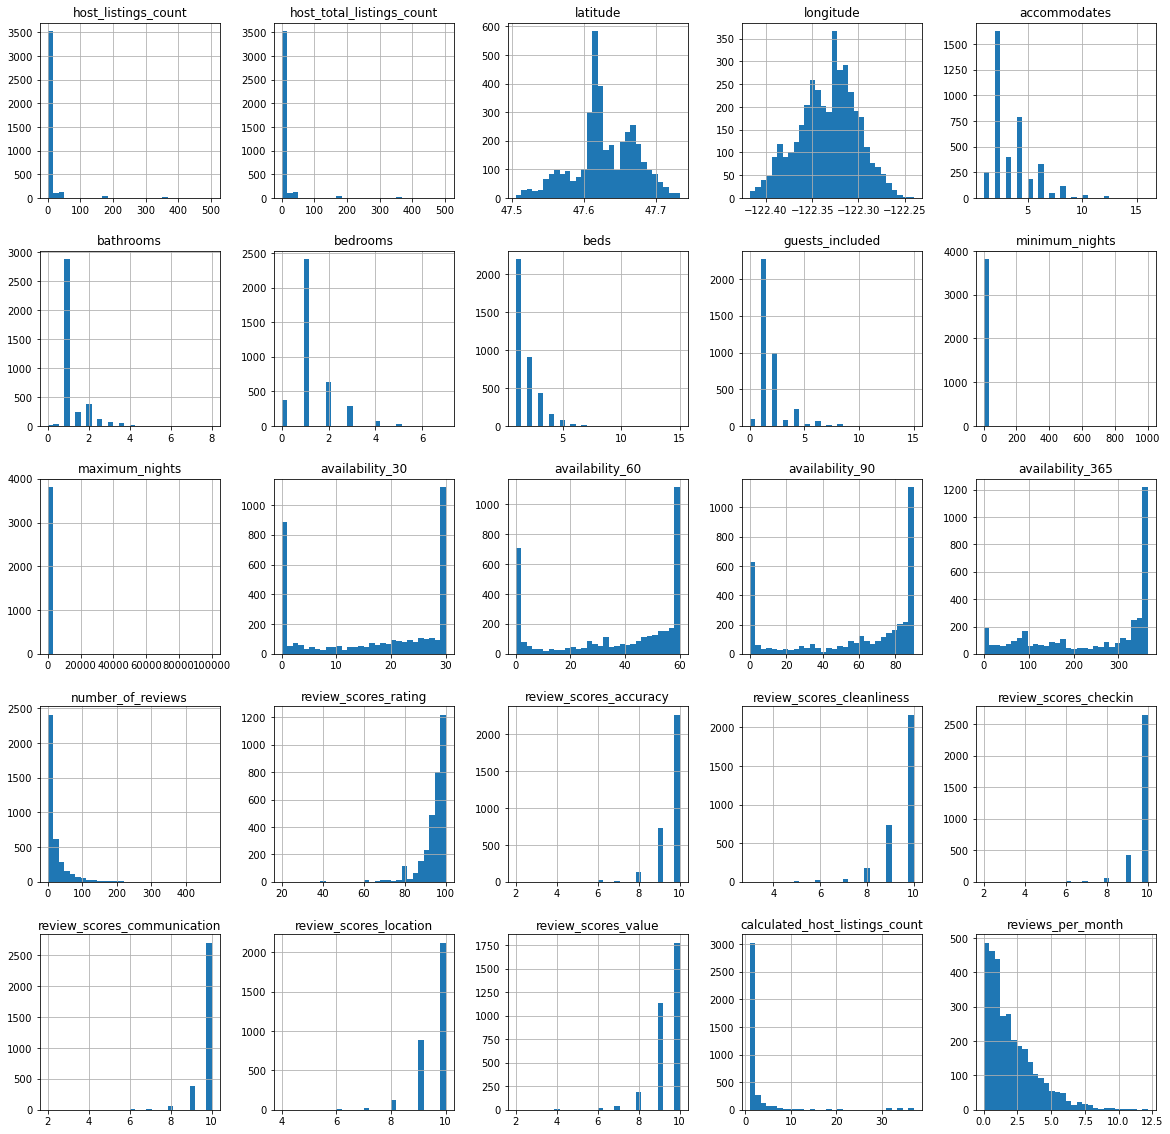

In [17]:
# histograms
cont_vars = list(df_listing_drop.select_dtypes(include=['int64' , 'float64']).columns)
df_listing_drop[cont_vars].hist(bins=30, figsize=(20, 20));

# outliers in minimum_nights maximum_nights?
# U-shape distribution of availability_ columns

## Clean-up and drop based on Categorical & Continuous fields analysis

* Recode: 
    * Price
    * Calculate time_since and then drop: first_review, last_review, host_since
    * To a number: host_response_rate, host_acceptance_rate
* Remove the following fields:
    * state: all either WA or wa
    * zipcode: (use neighbourhood instead zipcode)
    * weekly_price, monthly_price: derivations of price
* Drop but come back to if time:
    * host_neighbourhood - lots of categories
    * amenities, host_verifications are lists.
    * host_location could look at US/not US or Seattle not Seattle but most are Seattle so likely not useful.
* Based on continuous variables analysis - come back to if time:
    * Remove/investigate outliers
    * Create binary fields 0 or >0 for many fields
    * Normalize - if needed for the model of choice

### New columns

In [18]:
# Price
# Look is all the prices are in dollars before converting
# df_listing_drop['test'] = df_listing_drop['price'].astype(str).str[0]
# df_listing_drop['test'].value_counts()

# Convert to a number
df_listing['price_new'] = df_listing['price'].replace('[$,]', '', regex=True).astype(float)
 
# Thost_response_rate, host_acceptance_rate
# Other than Missings - do they all contain a % (make sure that 1 is not 100%)
# df_listing_drop['test']  = df_listing_drop['host_acceptance_rate'].str.count('%')
# df_listing_drop['test'].value_counts()

# Convert to a number
df_listing['host_response_rate_new'] = df_listing['host_response_rate'].replace('%', '', regex=True).astype(float)
df_listing['host_acceptance_rate_new'] = df_listing['host_acceptance_rate'].replace('%', '', regex=True).astype(float)

# property_type (House, Apartment, Other, NULL)
df_listing['property_type_new'] = df_listing['property_type'] \
.apply(lambda x: 'House' if x == "House" else ('Apartment' if x == "Apartment" else 'Other') )
# Coding missings as other but might come back to this

# bed_type(Real Bed, Other, NULL)
df_listing['bed_type_new'] = df_listing['bed_type'] \
.apply(lambda x: 'Real Bed' if x == "Real Bed" else 'Other' )
# Coding missings as other but might come back to this

# Calculate time_since and then drop: first_review, last_review, host_since
df_listing["last_scraped_dt"]= pd.to_datetime(df_listing["last_scraped"])
df_listing["first_review_dt"]= pd.to_datetime(df_listing["first_review"])
df_listing["last_review_dt"]= pd.to_datetime(df_listing["last_review"])
df_listing["host_since_dt"]= pd.to_datetime(df_listing["host_since"])

df_listing['days_since_first_review']  = (df_listing['last_scraped_dt'] - df_listing['first_review_dt']).dt.days
df_listing['days_since_last_review']   = (df_listing['last_scraped_dt'] - df_listing['last_review_dt']).dt.days
df_listing['days_since_host_since']    = (df_listing['last_scraped_dt'] - df_listing['host_since_dt']).dt.days

# remove old columns
columns_new = ['host_response_rate', 'host_acceptance_rate', 'price', 'bed_type', 'property_type' 
                      , 'first_review' , 'last_review' , 'host_since'
                      , 'last_scraped_dt', 'first_review_dt' , 'last_review_dt' , 'host_since_dt' ]
df_listing_new = df_listing.drop(columns_new, axis=1  )

df_listing_new.head()

# Haven't added these to my drop dictionary

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_location,host_about,host_response_time,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,room_type,accommodates,bathrooms,bedrooms,beds,amenities,square_feet,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,price_new,host_response_rate_new,host_acceptance_rate_new,property_type_new,bed_type_new,days_since_first_review,days_since_last_review,days_since_host_since
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Entire home/apt,4,1.0,1.0,1.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07,85.0,96.0,100.0,Apartment,Real Bed,1525.0,2.0,1607.0
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Entire home/apt,4,1.0,1.0,1.0,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48,150.0,98.0,100.0,Apartment,Real Bed,868.0,6.0,1047.0
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,

### Extra Drop

In [19]:
# Update drop dictionary
drop_vars_dict.update({'state': 'single value'})
drop_vars_dict.update({'zipcode': 'too many categories'})
drop_vars_dict.update({'weekly_price': 'derived from price'})    
drop_vars_dict.update({'monthly_price': 'derived from price'})    
    
drop_vars_dict.update({'host_neighbourhood': 'come back to if time'}) 
drop_vars_dict.update({'amenities': 'come back to if time'}) 
drop_vars_dict.update({'host_verifications': 'come back to if time'}) 
drop_vars_dict.update({'host_location': 'come back to if time'}) 


# Apply the drop 

drop_vars2 = [*drop_vars_dict.keys()]
df_listing_drop2 = df_listing_new.drop(drop_vars2, axis = 1)
df_listing_drop2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 47 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   last_scraped                      3818 non-null   object 
 1   host_is_superhost                 3816 non-null   object 
 2   host_listings_count               3816 non-null   float64
 3   host_total_listings_count         3816 non-null   float64
 4   host_has_profile_pic              3816 non-null   object 
 5   host_identity_verified            3816 non-null   object 
 6   neighbourhood_group_cleansed      3818 non-null   object 
 7   latitude                          3818 non-null   float64
 8   longitude                         3818 non-null   float64
 9   is_location_exact                 3818 non-null   object 
 10  room_type                         3818 non-null   object 
 11  accommodates                      3818 non-null   int64  
 12  bathro

## Output as csv

In [20]:
# Columns dropped plus reason.
drop_vars_dict

{'license': 'single value',
 'square_feet': 'missing values',
 'id': 'id or url in name',
 'listing_url': 'id or url in name',
 'scrape_id': 'single value',
 'thumbnail_url': 'id or url in name',
 'medium_url': 'id or url in name',
 'picture_url': 'id or url in name',
 'xl_picture_url': 'id or url in name',
 'host_id': 'id or url in name',
 'host_url': 'id or url in name',
 'host_thumbnail_url': 'id or url in name',
 'host_picture_url': 'id or url in name',
 'name': 'Text',
 'summary': 'Text',
 'space': 'Text',
 'description': 'Text',
 'neighborhood_overview': 'Text',
 'notes': 'Text',
 'transit': 'Text',
 'host_name': 'Text',
 'host_about': 'Text',
 'host_response_time': 'Text',
 'street': 'Text',
 'neighbourhood': 'Text',
 'neighbourhood_cleansed': 'Text',
 'city': 'single value',
 'smart_location': 'Text',
 'country': 'single value',
 'calendar_updated': 'Text',
 'experiences_offered': 'single value',
 'market': 'single value',
 'country_code': 'single value',
 'has_availability': '

In [21]:
#Columns dropped as new more powerful variables derived from them.
columns_new

['host_response_rate',
 'host_acceptance_rate',
 'price',
 'bed_type',
 'property_type',
 'first_review',
 'last_review',
 'host_since',
 'last_scraped_dt',
 'first_review_dt',
 'last_review_dt',
 'host_since_dt']

In [22]:
# final output
df_listing_drop2.to_csv('./listings_clean.csv', index=False)